<h1> Data Analysis for REYeker</h1>

In [1]:
# lib for dataframes
import pandas as pd

# lib for saving np images
from PIL import Image

# lib for plotting
%matplotlib inline
import matplotlib.pyplot as plt

# lib for numerical computations
import numpy as np

# lib for regex
import re

# lib for crerating paths
from pathlib import Path

# REYeker lib
import modules.rEYEkerAnalysis as rEYEker

# for t testing
from scipy import stats

# lib for better plotting
import seaborn as sns
sns.set_theme('paper')

# lib for differ calculation
import difflib

#" 2 4 7 8 9 10 9 10 9 10 9 10 12 "

<h2>1. Configuration</h2>

<h5>Database configuration </h5>

In [2]:
# path to the datafile
config_datasheet_path = r'./Book4.xlsx'

# columns with visual stimulus data
config_visual_stimulus_variable_array = ['BR21_01', 'BI21_01', 'TR21_01', 'TI21_01']

# columns with names of the algo
config_algo_names = ['BR_ReverseString','BI_ReverseString','TR_ReverseString','TI_ReverseString']

# columns with time data of visual stimulus
config_time_variable_array = []

# columns with the given answers of the studen
config_answer_variable_array = ['BR14_01', 'BI14_01', 'TR14_01', 'TI14_01']

# regex pattern for correct answer
config_answer_pattern_array = ['gnikcar[tT].*ey[eE]','gnikcar[tT].*ey[eE]','gnikcar[tT].*ey[eE]','gnikcar[tT].*ey[eE]']

# colums of response time
config_response_time_variable_array = ['TIME044','TIME010','TIME057','TIME027']

<h5>Configuration for REYEker data </h5>

In [3]:
# file for loading rEYEker settings
config_reyeker_settings_path = "data/example.json"

<h5>Configuration for saving images </h5>

In [4]:
# data for loading the images
config_image_path_array = ['images/BR/BR_ReverseString.png',
                          'images/BI/BI_ReverseString.png',
                          'images/TR/TR_ReverseString.png',
                          'images/TI/TI_ReverseString.png']

# where to save to heatmaps and sequence diagrams
config_folder_prefix_array = ['BR/',
                            'BI/',
                            'TR/',
                             'TI/']

# used for saving the heatmaps and sequence diagrams
config_image_prefix_array = [ 'BR_ReverseString_',
                            'BI_ReverseString_',
                            'TR_ReverseString_',
                             'TI_ReverseString_']



<h5>Configuration for Code Flow data import</h5>

In [5]:
# excel data in data/code_flow
config_code_flow_datasheet_array = [
    'BR_ReverseString.xlsx',
    'BI_ReverseString.xlsx',
    'TR_ReverseString.xlsx',
    'TI_ReverseString.xlsx']  



<h5>Configuration for alpha value for t-test </h5>

In [6]:
# confidence needed for t test
config_alpha = 0.05

<h5>Import the columns and create dataframe</h5>

In [7]:
needed_columns_array = []

# create all dataframe headers
for i in range(len(config_visual_stimulus_variable_array)):
    tmp_list = []
    tmp_list.append(config_visual_stimulus_variable_array[i])
    
    if len(config_time_variable_array) != 0:
        tmp_list.append(config_time_variable_array[i])

    tmp_list.append(config_answer_variable_array[i])
    tmp_list.append(config_response_time_variable_array[i])
    needed_columns_array.append(tmp_list)

df_array = []
raw = pd.read_excel(config_datasheet_path)

# read all dataframes
for data_set in needed_columns_array:
    dataframe = pd.DataFrame(raw, columns = data_set)
    dataframe = dataframe.iloc[1:]
    dataframe = dataframe.dropna()
    df_array.append(dataframe)

<h4>Splitting Dataframes in right and wrong answers.</h4>

In [8]:
df_array_right = []
df_array_wrong = []

# iter over every dataframe
for idx, dataframe in enumerate(df_array):
    right_answer_pattern = config_answer_pattern_array[idx]
    regex = re.compile(right_answer_pattern)
    answer_field = config_answer_variable_array[idx]
    
    dataframe_right = pd.DataFrame(columns = needed_columns_array[idx])
    dataframe_wrong = pd.DataFrame(columns = needed_columns_array[idx])
    
    # iter over every row and check if the result is rightr
    for _idx, row  in dataframe.iterrows():
        result = regex.match(str(row[answer_field]))
        if result is not None:
            dataframe_right = dataframe_right.append(row)
        else:
            dataframe_wrong = dataframe_wrong.append(row)
    
    
    
    df_array_right.append(dataframe_right)
    df_array_wrong.append(dataframe_wrong)

<h4>Remove Outliers</h4>

In [9]:
tmp_df_array = []
tmp_df_array_wrong = []

#iterate over all dataframes and remove outliers
for idx, dataframe in enumerate(df_array_right):

    data = dataframe[config_response_time_variable_array[idx]]
    cleared_dataframe = dataframe[data.between(data.quantile(.15), data.quantile(0.85))]
    tmp_df_array.append(cleared_dataframe)
    
#iterate over all dataframes and remove outliers
for idx, dataframe in enumerate(df_array_wrong):
    data = dataframe[config_response_time_variable_array[idx]]
    cleared_dataframe = dataframe[data.between(data.quantile(.15), data.quantile(0.85))]
    tmp_df_array_wrong.append(cleared_dataframe)
    
df_array = tmp_df_array
df_array_wong = tmp_df_array_wrong

<h4>Import REYeker Settings</h4>

In [10]:
(_data, _times, click_setting) = rEYEker.load_data_from_json(config_reyeker_settings_path)

<h4>Import Images Settings</h4>

In [11]:
image_array = []

# read in every image
for image_path in config_image_path_array:
    img = rEYEker.load_image(image_path)
    image_array.append(img)

<h4> Cast Data to Valid format</h4>

Import the visual stimulus measured Data

In [12]:
visual_stimulus_data_matrix = []

#iter over every dataframe
for idx, dataframe in enumerate(df_array):
    visual_stimulus_array = []
    visual_stimulus_row = config_visual_stimulus_variable_array[idx]

    #iter over every row 
    for _idx, item in dataframe.iterrows():
        data_str = item[visual_stimulus_row]
        data_str = data_str.strip()
        coordinates_str = data_str.split(" ")
        coordinates = []
        
        # iter over every coordinate pair x-y
        for coordinate_str in coordinates_str:
            coordinate = coordinate_str.split("-")
            coordinate = (int(coordinate[0]), int(coordinate[1]))
            coordinates.append(coordinate)
            
        visual_stimulus_array.append(coordinates)
        
    visual_stimulus_data_matrix.append(visual_stimulus_array)

Import the Time Data

In [13]:
timestamps_data_matrix = []

#iter over every dataframe
for idx, dataframe in enumerate(df_array):
    if len(config_time_variable_array) <= idx:
        break
    time_measurements = []
    time_measurement_row = config_time_variable_array[idx]

    #iter over every row 
    for _idx, item in dataframe.iterrows():
        data_str = item[time_measurement_row]
        data_str = data_str.strip()
        timestamps = data_str.split(" ")
        timestamps = [int(timestamp) for timestamp in timestamps]
        time_measurement_row.append(timestamps)
        
    timestamps_data_matrix.append(visual_stimulus_measurements)

<h4>Helper Functions</h4>

In [14]:
def save_images(image_array, folder, image_name):
    """
    :brief saves an array of images to a certain location incrementing the postfix by a number
    :param image_array:        array of images (np.ndarray)
    :param folder:     prefix of image/ folder location
    :param image_name: prefix for the image
    """
    
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    prefix = folder + image_name
    
    #TODO create folders if there are none present
    for idx, data in enumerate(image_array):
        data = data*255
        data = np.uint8(data)
        im = Image.fromarray(data)
        im.save(prefix + str(idx) + '.png')
        
def compare_for_h0(arr_1, arr_2, alpha):
    t, p = stats.ttest_ind(arr_1, arr_2)
    if p > alpha:
        return True, t, p
    else:
        return False, t, p
    
def is_in(value, tup):
    return tup[0] <= value <= tup[1]

def get_0_offset(number):
    i = 0
    number = int(number)
    while number != 0:
        number = int(number / 10)
        i = i + 1
    return i

<h2>2. Create Single Heatmaps</h2>

create heatmaps

In [15]:
heatmaps_matrix = []

# iterate over all the datasets
for dataset_idx, stimulus_dataset in enumerate(visual_stimulus_data_matrix):
    time_stamp_array = None
    if len(timestamps_data_matrix) > dataset_idx:
        time_stamp_array = timestamps_data_matrix[dataset_idx]
    heatmap_array = []

    # iterate over all the measurements of the dataset
    for visual_idx, stimulus_measurement in enumerate(stimulus_dataset):
        times = None
        if time_stamp_array is not None and len(time_stamp_array) > visual_idx:
            times = time_stamp_array[visual_idx]
        im = rEYEker.draw_shape_heat_map(image_array[dataset_idx], stimulus_measurement,click_setting, time_stamps=times, should_copy=True)
        heatmap_array.append(im)
        
    heatmaps_matrix.append(heatmap_array)

8


save Heatmaps

In [16]:
for idx, heatmap_array in enumerate(heatmaps_matrix):
    save_images(heatmap_array, "./results/ReverseString/heatmaps/heatmaps/" +  config_folder_prefix_array[idx], config_image_prefix_array[idx])

<h2>3. Create Average Heatmaps</h2>

create heatmaps

In [17]:
average_heatmap_array = []
avergae_heatmask_array = []

# iterate over all the datasets
for idx, stimulus_dataset in enumerate(visual_stimulus_data_matrix):
    image = image_array[idx]
    visual_measurements = visual_stimulus_data_matrix[idx]
    time_measurements = None
    if len(timestamps_data_matrix) > idx:
        time_measurements = timestamps_data_matrix[idx]
    im, mask = rEYEker.draw_average_shape_heat_map_rel(image, visual_measurements, click_setting, 1.0, .0, time_measurements, should_copy=True)
    average_heatmap_array.append(im)
    avergae_heatmask_array.append(mask)

save heatmaps

In [18]:
for idx, heatmap in enumerate(average_heatmap_array):
    save_images([heatmap], "./results/ReverseString/heatmaps/average_heatmap/", config_image_prefix_array[idx])

<h2>4. Create Sequence diagramms</h2>

create sequence diagrams

In [19]:
sequence_diagrams_matrix = []

# iterate over all the datasets
for dataset_idx, stimulus_dataset in enumerate(visual_stimulus_data_matrix):
    #if time will be needed someday
    #time_stamp_array = None
    #if len(timestamps_data_matrix) > dataset_idx:
    #    time_stamp_array = timestamps_data_matrix[dataset_idx]
    
    sequence_diagram_array = []

    # iterate over all the measurements of the dataset
    for visual_idx, stimulus_measurement in enumerate(stimulus_dataset):
        #if time will be needed someday
        #times = None
        #if time_stamp_array is not None and len(time_stamp_array) > visual_idx:
        #    times = time_stamp_array[visual_idx]
        try:
            im = rEYEker.draw_vertical_line_diagram(image_array[dataset_idx], stimulus_measurement, should_copy=True)
            sequence_diagram_array.append(im)
        except:
            #TODO
            print("W.I.P.:", end='')
            print("to many clicks for dataset " + str(dataset_idx) + " datset " + str(visual_idx))
    sequence_diagrams_matrix.append(sequence_diagram_array)

save sequence diagrams

In [20]:
for idx, sequence_diagram_array in enumerate(sequence_diagrams_matrix):
    save_images(sequence_diagram_array, "./results/ReverseString/sequence_diagrams/"  +  config_folder_prefix_array[idx], config_image_prefix_array[idx])

<h2>7. Analyse average of Data</h2>

<h3>7.1 Helper Functions</h3>

In [21]:
def save_displots(folder, indexing_array, df_array):
    """
    folder:         prefix where to save
    indexing_array: how to index into the dataframe
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    for idx, dataframe in enumerate(df_array):
        values = dataframe[indexing_array[idx]].values.astype(float)
        sns_plot = sns.displot(data=values, kde=True)
        sns_plot.savefig(folder + config_image_prefix_array[idx] + ".png")
        plt.close()

        
def save_combined_displot(folder, x_axis, dataframe):
    """
    folder:         prefix where to save
    x_axis:         value to use for x_axis
    dataframe:      dataframe with "Algorithm" field
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.displot(data=dataframe, x=x_axis, hue="Algorithm", kind="kde")
    sns_plot.savefig(folder + "Combined_Displot.png")
    plt.close()

In [22]:
def save_barplot(folder, y_axis, df_array):
    """
    folder:         prefix where to save
    y_axis:         value to use for y_axis
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.barplot(y=y_axis, x='Algorithm', data=df_array, hue='Algorithm', estimator=np.median)
    sns_plot.legend_.remove()
    sns_plot.figure.savefig(folder + "Combined_Barplot.png")
    plt.close()

In [23]:
def save_boxplot(folder, y_axis, df_array):
    """
    folder:         prefix where to save
    y_axis:         value to use for y_axis
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.boxplot(y=y_axis, x='Algorithm', data=df_array, hue='Algorithm')
    sns_plot.legend_.remove()
    sns_plot.figure.savefig(folder + "Combined_Boxplot.png")
    plt.close()

In [24]:
def save_violinplot(folder, y_axis, df_array):
    """
    folder:         prefix where to save
    y_axis:         value to use for y_axis
    df_array:     array of dataframes to plot
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    sns_plot = sns.violinplot(y=y_axis, x='Algorithm', data=df_array, hue='Algorithm')
    sns_plot.legend_.remove()
    sns_plot.figure.savefig(folder + "Combined_Violinplot.png")
    plt.close()

In [25]:
def save_implots(folder, x_df, x_axis, y_df, y_axis):
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    tmp_list = []
    for idx in range(len(x_df)):
        x_val = x_df[x_axis][idx]
        y_val = y_df[y_axis][idx]
        algorithm = x_df['Algorithm'][idx]
        tmp_list.append([x_val, y_val, algorithm])
        
    df_tmp = pd.DataFrame(tmp_list, columns=[x_axis, y_axis, 'Algorithm'])
    for idx in range(len(config_algo_names)):
        tmp_df = df_tmp[df_tmp["Algorithm"] == config_algo_names[idx]]
        sns_plot = sns.lmplot(data=tmp_df, x=x_axis, y=y_axis)
        sns_plot.set(ylim=(0, None))
        sns_plot.savefig(folder + config_algo_names[idx] + str(idx) + ".png")
        plt.close()

def save_combined_implot(folder, x_df, x_axis, y_df, y_axis):
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    tmp_list = []
    for idx in range(len(x_df)):
        x_val = x_df[x_axis][idx]
        y_val = y_df[y_axis][idx]
        algorithm = x_df['Algorithm'][idx]
        tmp_list.append([x_val, y_val, algorithm])
        
    df_tmp = pd.DataFrame(tmp_list, columns=[x_axis, y_axis, 'Algorithm'])
    sns_plot = sns.lmplot(data=df_tmp, x=x_axis, y=y_axis, hue="Algorithm")
    sns_plot.set(ylim=(0, None))
    sns_plot.savefig(folder + "Combined_Implot.png")
    plt.close()

<h3>7.2 Response Time</h3>

Create new Dataframe which holds all the response time data

In [26]:
columns = ['Response Time', 'Algorithm']
data = []
for idx, dataframe in enumerate(df_array):
    for _idx, row in dataframe.iterrows():
        data.append([row[config_response_time_variable_array[idx]], config_algo_names[idx]])
algo_df = pd.DataFrame(data, columns=columns)

Create and Save Displots

In [27]:
save_displots("./results/ReverseString/responseTime/displots/", config_response_time_variable_array, df_array)

save_combined_displot("./results/ReverseString/responseTime/displots/", "Response Time", algo_df)

Create and save barplots

In [28]:
save_barplot("./results/ReverseString/responseTime/barplot/", 'Response Time', algo_df)

Create and save boxplot

In [29]:
save_boxplot("./results/ReverseString/responseTime/boxplot/", 'Response Time', algo_df)

Create and save violinplot

In [30]:
save_violinplot("./results/ReverseString/responseTime/violinplot/", 'Response Time', algo_df)

In [ ]:
return

<h2>8. Areas of Interest </h2>

<h3>8.1. Helper</h3>

In [31]:
from matplotlib.patches import Rectangle

def save_aoi_sequences(folder, image, image_prefix, aoi_mask, aoi_names, visual_measurement_array):
    
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    color = []
    
    for idx, visual_measurement in enumerate(visual_measurement_array):
        im = image.copy()
        
        x = [x for (x,y) in visual_measurement]
        y = [y for (x,y) in visual_measurement]
        
        cats = [int(aoi_mask[y,x]) for (x,y) in visual_measurement]
        classes = [aoi_names[idx] for idx in cats]

        val = [idx for idx in aoi_names]
        for value in classes:
            val.append(value)
        
        classes = val
        
        df_classes = pd.DataFrame(classes, columns=["aois"])
        incremental_step = float(df_classes['aois'].value_counts().max()-1)/float(len(cats) - 1)
        
        y_val = [1+i*incremental_step for i in range(len(cats))]
        x_val = cats
        
        fig, ax1 = plt.subplots(figsize=(6,6))
        
        sns.countplot(x="aois", data=df_classes, ax=ax1);
        ax1.plot(x_val, y_val, '-o', linewidth=2, color='black');
        
        ax1.figure.savefig(folder + image_prefix + "aoi_sequence_" + str(idx) + ".png")
        ax_color = ax1
        
        bars = [r for r in ax_color.get_children() if type(r)==Rectangle]
        colors = [c.get_facecolor() for c in bars[:-1]]
        colors = [[r,g,b] for (r,g,b,a) in colors]
        color= np.array(colors).astype(np.float32)
        plt.close()
    
    return color

def apply_aoi_mask(image, colors, aoi_mask):
    im = image.copy()
    for height in range(im.shape[0]):
        for width in range(im.shape[1]):
            im[height, width] = 0.4 * im[height, width] + 0.6 * colors[aoi_mask[height, width]]
    return im

<h3>8.2. Areas of Interest supervised </h3>

In [32]:
import modules.HeatmapHelpers as heathelpers


im = image_array[0].copy()
shape = im.shape[0], im.shape[1]

aoi_mask = np.zeros(shape).astype(int)
aoi_mask[50:180, 50:700] = 1
aoi_mask[200:350, 50:900] = 2

aoi_names = ["None", "main", "fibonacci"]

colors = save_aoi_sequences("./results/aois/supervised/" + config_folder_prefix_array[0], image_array[0], config_image_prefix_array[0], aoi_mask, aoi_names, visual_stimulus_data_matrix[0])

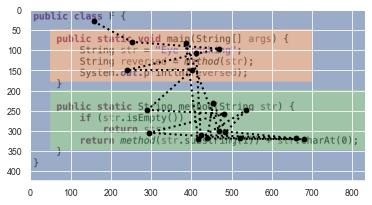

In [33]:
fig, ax = plt.subplots(figsize=(6,6))

im = apply_aoi_mask(image_array[0], colors, aoi_mask)

x = [x for (x,y) in visual_stimulus_data_matrix[0][0]]
y = [y for (x,y) in visual_stimulus_data_matrix[0][0]]

ax.imshow(im)
ax.plot(x, y, ':o', linewidth=2, color='black');

In [34]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,8));
ax.set_ylim((0, 416))
ax.set_xlim((0, 870))
ax.invert_yaxis()

ax.imshow(image_array[0])
line, = ax.plot([], [], "k-x", lw=2)

def init():
    line.set_data([], [])
    return (line,)


x_glob = np.array([x for (x,y) in visual_stimulus_data_matrix[0][0]])
y_glob = np.array([y for (x,y) in visual_stimulus_data_matrix[0][0]])

len_value = len(x_glob)

def animate(i):
    low = max(0, i-8)
    x = x_glob[low:i]
    y = y_glob[low:i]

    image = rEYEker.draw_shape_heat_map(image_array[0], visual_stimulus_data_matrix[0][0], click_setting, min_idx=low, max_idx=i, should_copy=True)
    ax.imshow(image)
    
    line.set_data(x,y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len_value, interval=100, blit=True)
plt.close()

In [ ]:
HTML(anim.to_html5_video())